## Step 0. Imports and Constants

In [1]:
# install packages
!pip3 install -U torch torchvision --extra-index-url https://download.pytorch.org/whl/cu116
!pip3 install python-gdcm pylibjpeg pylibjpeg-libjpeg pydicom

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu116
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 GB 578.9 kB/s eta 0:00:0000:010:02m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.2/24.2 MB 51.9 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0
    Uninstalling torch-1.11.0:
      Successfully uninstalled torch-1.11.0
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.12.0
    Uninstalling torchvision-0.12.0:
      Successfully uninstalled torchvision-0.12.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
allennlp 2.10.1 requires torch<1.13.0,>=1.10.0, but you have torch 1.13.0+cu116 which is incompatible.
allennlp 2.10.1 requires torchvision<0.14.0,>=0.8.1, but you have torchvision 0.14.0+cu116 which is incompatible.
     ━━━━━━━━━━━━

In [1]:
# import libraries
import os
import gc
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import torch
import torchvision as tv
from torchvision import transforms
from torchvision.models.feature_extraction import create_feature_extractor
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [2]:
# specify paths and parameters
PATH_MAIN = '../input/rsna-2022-cervical-spine-fracture-detection'
PATH_IMAGES = f'{PATH_MAIN}/train_images'
PATH_FRACTURE = f'{PATH_MAIN}/train.csv'
PATH_SEGMENTATION = '../input/rsna-2022-spine-fracture-detection-metadata/train_segmented.csv'  # to be changed
PATH_MODELS = '../input/fracture-detection-models'

IMAGE_SHAPE = (512, 512)
NUM_VERTEBRAE = 7
NUM_FOLDS = 5
SEED = 0
BATCH_SIZE = 32
RATIO = 2

In [3]:
# use PyTorch CUDA for computation
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Device: {DEVICE}')

Device: cuda


## Step 1. Load Data

In [4]:
def load_image(image_path):
    '''
    Load image data from given path. Return the image pixel array and the file metadata.
    
    Parameters:
        image_path: str
            Path to the dicom file of the target image.
    
    Return:
        image: numpy.ndarray
            The image pixel array with shape (H, W, C) in which C = 3 (RGB image).
            Pixel values range from 0 to 255.
        metadata: pydicom.dataset.FileDataset
            The metadata of the dicom file.
    '''
    # load metadata and alter photometric interpretation of image pixels
    metadata = pydicom.dcmread(image_path)
    # extract image pixel array and rescale to [0, 255]
    image = apply_voi_lut(metadata.pixel_array, metadata)
    if image.shape != IMAGE_SHAPE:
        image = cv2.resize(image, dsize=IMAGE_SHAPE, interpolation=cv2.INTER_CUBIC)
    image = 255 * ((image - np.min(image)) / (np.max(image) - np.min(image)))
    # change image dtype and convert to RGB
    image = image.astype(np.uint8)
    image = np.stack([image] * 3, axis=-1)
    return image, metadata

image shape: (512, 512, 3)
pixel range: [0, 255]


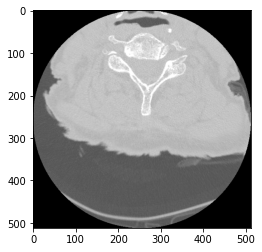

In [6]:
# load an image
image, metadata = load_image(f'{PATH_IMAGES}/1.2.826.0.1.3680043.17625/150.dcm')
print(f'image shape: {image.shape}')
print(f'pixel range: [{np.min(image)}, {np.max(image)}]')
plt.imshow(image)
plt.show()

In [5]:
df_fracture = pd.read_csv(PATH_FRACTURE)
df_fracture.head()

,StudyInstanceUID,patient_overall,C1,C2,C3,C4,C5,C6,C7
0,1.2.826.0.1.3680043.6200,1,1,1,0,0,0,0,0
1,1.2.826.0.1.3680043.27262,1,0,1,0,0,0,0,0
2,1.2.826.0.1.3680043.21561,1,0,1,0,0,0,0,0
3,1.2.826.0.1.3680043.12351,0,0,0,0,0,0,0,0
4,1.2.826.0.1.3680043.1363,1,0,0,0,0,1,0,0


In [6]:
df_segmentation = pd.read_csv(PATH_SEGMENTATION)
cols = [f'C{i}' for i in range(1, NUM_VERTEBRAE+1)]
#df_segmentation[cols] = (df_segmentation[cols] > 0.5).astype(int)
df_segmentation.head()

,StudyInstanceUID,Slice,ImageHeight,ImageWidth,SliceThickness,ImagePositionPatient_x,ImagePositionPatient_y,ImagePositionPatient_z,C1,C2,C3,C4,C5,C6,C7
0,1.2.826.0.1.3680043.10001,1,512,512,0.625,-52.308,-27.712,7.282,0.005208,0.015055,0.003290,0.000895,0.001614,0.004632,0.002570
1,1.2.826.0.1.3680043.10001,2,512,512,0.625,-52.308,-27.712,6.657,0.005675,0.015945,0.002117,0.000562,0.001265,0.005648,0.004136
2,1.2.826.0.1.3680043.10001,3,512,512,0.625,-52.308,-27.712,6.032,0.006624,0.030292,0.003079,0.000677,0.000882,0.002238,0.002877
3,1.2.826.0.1.3680043.10001,4,512,512,0.625,-52.308,-27.712,5.407,0.006572,0.022294,0.003103,0.000975,0.001164,0.002434,0.002715
4,1.2.826.0.1.3680043.10001,5,512,512,0.625,-52.308,-27.712,4.782,0.004945,0.022388,0.003236,0.000826,0.000662,0.002304,0.006849


In [7]:
df_fracture = df_segmentation.set_index('StudyInstanceUID').join(
    df_fracture.set_index('StudyInstanceUID'),
    rsuffix='_frac'
).reset_index().copy()
# delete problematic instance
df_fracture = df_fracture[df_fracture.StudyInstanceUID != "1.2.826.0.1.3680043.20574"]
df_fracture = df_fracture.reset_index(drop=True)
df_fracture.head()

,StudyInstanceUID,Slice,ImageHeight,ImageWidth,SliceThickness,ImagePositionPatient_x,ImagePositionPatient_y,ImagePositionPatient_z,C1,C2,...,C6,C7,patient_overall,C1_frac,C2_frac,C3_frac,C4_frac,C5_frac,C6_frac,C7_frac
0,1.2.826.0.1.3680043.10001,1,512,512,0.625,-52.308,-27.712,7.282,0.005208,0.015055,...,0.004632,0.002570,0,0,0,0,0,0,0,0
1,1.2.826.0.1.3680043.10001,2,512,512,0.625,-52.308,-27.712,6.657,0.005675,0.015945,...,0.005648,0.004136,0,0,0,0,0,0,0,0
2,1.2.826.0.1.3680043.10001,3,512,512,0.625,-52.308,-27.712,6.032,0.006624,0.030292,...,0.002238,0.002877,0,0,0,0,0,0,0,0
3,1.2.826.0.1.3680043.10001,4,512,512,0.625,-52.308,-27.712,5.407,0.006572,0.022294,...,0.002434,0.002715,0,0,0,0,0,0,0,0
4,1.2.826.0.1.3680043.10001,5,512,512,0.625,-52.308,-27.712,4.782,0.004945,0.022388,...,0.002304,0.006849,0,0,0,0,0,0,0,0


In [8]:
# split the dataset into folds by Group K-Fold mechanism
# ensure that the slices from the same patient do not appear in training and test set simultaneously
np.random.seed(SEED)
group_kfold = GroupKFold(NUM_FOLDS)
folds = group_kfold.split(df_fracture, groups=df_fracture.StudyInstanceUID)
for fold, (_, test_indices) in enumerate(folds):
    df_fracture.loc[test_indices, 'Fold'] = fold
df_fracture.iloc[:,-1] = df_fracture.iloc[:,-1].astype(np.uint8)
print(f'fold indices: {sorted(df_fracture.Fold.unique())}')
df_fracture.sample(5)

fold indices: [0, 1, 2, 3, 4]


,StudyInstanceUID,Slice,ImageHeight,ImageWidth,SliceThickness,ImagePositionPatient_x,ImagePositionPatient_y,ImagePositionPatient_z,C1,C2,...,C7,patient_overall,C1_frac,C2_frac,C3_frac,C4_frac,C5_frac,C6_frac,C7_frac,Fold
521248,1.2.826.0.1.3680043.31629,364,512,512,0.500,-54.546360,-54.546360,1950.800,0.003047,0.002479,...,0.998291,0,0,0,0,0,0,0,0,3
134087,1.2.826.0.1.3680043.15981,219,512,512,0.625,-93.798000,-81.500000,-100.673,0.998779,0.998047,...,0.000398,1,0,0,0,0,1,0,0,3
332702,1.2.826.0.1.3680043.23765,118,512,512,1.000,-69.874200,-11.749270,-537.100,0.008820,0.032127,...,0.002068,1,0,1,1,0,0,0,0,1
307904,1.2.826.0.1.3680043.22780,15,512,512,0.625,-207.900000,-185.000000,59.250,0.007127,0.008546,...,0.020535,1,0,0,0,0,0,1,1,3
448799,1.2.826.0.1.3680043.28637,150,512,512,0.600,-41.354492,-228.854492,-459.600,0.006874,0.995117,...,0.001612,0,0,0,0,0,0,0,0,1


In [11]:
class ImageDataset(torch.utils.data.Dataset):
    '''
    An image dataset to extract slice images and their target labels.
    '''
    def __init__(self, df, image_dir):
        '''
        Initialize the image dataset.
        
        Parameters:
            df: pandas.core.frame.DataFrame
                The dataframe containing segmentation information of each slice.
            image_dir: str
                The path to the image directory.
        '''
        super().__init__()
        self.df = df
        self.image_dir = image_dir
    
    def __len__(self):
        '''
        Length of the dataset
        
        Return:
            length: int
                Total number of slices in the dataset.
        '''
        length = len(self.df)
        return length
    
    def __getitem__(self, idx):
        '''
        Retrieve the idx-th slice of the dataset and its corresponding labels.
        
        Parameters:
            idx: int
                The index of the slice in the dataset to retrieve.
        
        Return:
            image: torch.Tensor
                The tensor of slice image pixels in the shape of [C, H, W].
            vert: torch.Tensor
                The tensor of target vertebrae labels of the image in the shape of [NUM_VERTEBRAE].
            frac: torch.Tensor
                The tensor of target fracture labels of the image in the shape of [NUM_VERTEBRAE].
        '''
        # get path to the slice image
        patient_uid = self.df.iloc[idx].StudyInstanceUID
        slice_number = self.df.iloc[idx].Slice
        image_path = os.path.join(self.image_dir, patient_uid, f'{slice_number}.dcm')
        # load the slice image
        image, _ = load_image(image_path)
        # convert (H, W, C) to (C, H, W) in the PyTorch convention
        image = np.transpose(image, (2, 0, 1))
        # transform the image
        image = torch.as_tensor(image)
        
        # retrieve vertebrae labels
        vert = self.df.iloc[idx][cols].values
        vert = torch.as_tensor(vert.astype(np.float32))
        
        # retrieve fracture labels
        col_frac = [col + '_frac' for col in cols]
        frac = self.df.iloc[idx][col_frac].values
        frac = torch.as_tensor(frac.astype(np.float32))
        df_segmentation[cols] = (df_segmentation[cols] > 0.5).astype(int)
        frac *= (vert > 0.5).type(torch.float32)
        
        return image, vert, frac

In [12]:
# check image and labels retrieved from dataset
ds_fracture = ImageDataset(df_fracture, PATH_IMAGES)
image, vert, frac = ds_fracture[3336]
C, H, W = image.shape
print(f'image shape: {image.shape}')
print(f'vertebrae labels: {vert}')
print(f'fracture labels: {frac}')

image shape: torch.Size([3, 512, 512])
vertebrae labels: tensor([5.9783e-04, 6.1965e-04, 8.3113e-04, 5.0557e-04, 3.9062e-02, 9.9707e-01,
        9.8193e-01])
fracture labels: tensor([0., 0., 0., 0., 0., 1., 0.])


## Step 2. Model Construction

In [13]:
class Model(torch.nn.Module):
    '''
    Fracture detection model with single image input.
    '''
    def __init__(self, model, weights, feature_layer, feature_dim):
        '''
        Model initialization.
        
        Parameters:
            model: function
                The function to create the feature extraction model to retrieve image features.
            weights: enum
                Initial weights of the model.
            feature_layer: str
                Name of the layer to extract image features.
            feature_dim: int
                Dimension of image features.
        '''
        super().__init__()
        # image transformation procedures
        self.transform = weights.transforms()
        # feature extraction layer
        self.feature_layer = feature_layer
        # get flatten layer output, i.e., feature vector of the slice image
        self.model = create_feature_extractor(
            model(weights=weights),
            [feature_layer]
        )
        # fully connected layers to get vertebrae and fracture logits
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(feature_dim, 128),
            torch.nn.PReLU(),
            torch.nn.Linear(128, 32),
            torch.nn.PReLU(),
            torch.nn.Linear(32, 1),
        )

    def forward(self, image):
        '''
        Predict the fracture logit of the input image.
        
        Parameters:
            image: torch.Tensor
                The input image tensor of shape [B, C, H, W].
                
        Return:
            frac: torch.Tensor
                A tensor of shape [B, 1] indicating the fracture probability logit.
        '''
        image = self.transform(image)
        image = self.model(image)[self.feature_layer]  # shape [B, feature_dim]
        frac = self.fc(image)  # shape [B, 1]
        return frac
    
    def predict(self, image):
        '''
        Predict the fracture probability of the input image.
        
        Parameters:
            x: torch.Tensor
                The input image tensor of shape [B, C, H, W].
        
        Return:
            frac: torch.Tensor
                A tensor of shape [B, 1] indicating the fracture probability.
        '''
        frac = self.forward(image)
        frac = torch.nn.Sigmoid()(frac)
        return frac

In [14]:
class Multimodal(torch.nn.Module):
    '''
    Fracture detection model with multimodal learning.
    '''
    def __init__(self, model, weights, feature_layer, feature_dim):
        '''
        Model initialization.
        
        Parameters:
            model: function
                The function to create the feature extraction model to retrieve image features.
            weights: enum
                Initial weights of the model.
            feature_layer: str
                Name of the layer to extract image features.
            feature_dim: int
                Dimension of image features.
        '''
        super().__init__()
        # image transformation procedures
        self.transform = weights.transforms()
        # feature extraction layer
        self.feature_layer = feature_layer
        # get flatten layer output, i.e., feature vector of the slice image
        self.model = create_feature_extractor(
            model(weights=weights),
            [feature_layer]
        )
        # fully connected layers to get vertebrae and fracture logits
        self.fc_vert = torch.nn.Sequential(
            torch.nn.Linear(NUM_VERTEBRAE, 128),
            torch.nn.PReLU(),
            torch.nn.Linear(128, 128),
        )
        self.fc_frac = torch.nn.Sequential(
            torch.nn.Linear(feature_dim, 512),
            torch.nn.PReLU(),
            torch.nn.Linear(512, 128)
        )
        self.fc_fuse = torch.nn.Sequential(
            torch.nn.PReLU(),
            torch.nn.Linear(256, 128),
            torch.nn.PReLU(),
            torch.nn.Linear(128, 32),
            torch.nn.PReLU(),
            torch.nn.Linear(32, NUM_VERTEBRAE)
        )

    def forward(self, image, vert):
        image = self.transform(image)
        image = self.model(image)[self.feature_layer]  # shape [B, feature_dim]
        image = self.fc_frac(image)  # shape [B, 128]
        vert = self.fc_vert(vert)  # shape [B, 128]
        fused = torch.cat([image, vert], axis=-1)  # shape [B, 256]
        fused = self.fc_fuse(fused)  # shape [B, NUM_VERTEBRAE]
        return fused
    
    def predict(self, image, vert):
        frac = self.forward(image, vert)
        frac = torch.nn.Sigmoid()(frac)
        return frac

In [15]:
class Multitask(torch.nn.Module):
    '''
    Fracture detection model with multi-task learning.
    '''
    def __init__(self, model, weights, feature_layer, feature_dim):
        '''
        Model initialization.
        
        Parameters:
            model: function
                The function to create the feature extraction model to retrieve image features.
            weights: enum
                Initial weights of the model.
            feature_layer: str
                Name of the layer to extract image features.
            feature_dim: int
                Dimension of image features.
        '''
        super().__init__()
        # image transformation procedures
        self.transform = weights.transforms()
        # feature extraction layer
        self.feature_layer = feature_layer
        # get flatten layer output, i.e., feature vector of the slice image
        self.model = create_feature_extractor(
            model(weights=weights),
            [feature_layer]
        )
        # fully connected layers to get vertebrae and fracture logits
        self.fused = torch.nn.Sequential(
            torch.nn.Linear(feature_dim, 512),
            torch.nn.PReLU(),
            torch.nn.Linear(512, 256),
            torch.nn.PReLU()
        )
        self.fc_vert = torch.nn.Sequential(
            torch.nn.Linear(256, 64),
            torch.nn.PReLU(),
            torch.nn.Linear(64, NUM_VERTEBRAE)
        )
        self.fc_frac = torch.nn.Sequential(
            torch.nn.Linear(256, 64),
            torch.nn.PReLU(),
            torch.nn.Linear(64, NUM_VERTEBRAE)
        )

    def forward(self, image):
        '''
        Predict the vertebrae and fracture logits of all vertebrae.
        
        Parameters:
            image: torch.Tensor
                The input image tensor of shape [B, C, H, W].
        
        Return:
            vert: torch.Tensor
                A tensor of shape [B, NUM_VERTEBRAE] indicating the vertebrae probability logits.
            frac: torch.Tensor
                A tensor of shape [B, NUM_VERTEBRAE] indicating the fracture probability logits.
        '''
        image = self.transform(image)
        image = self.model(image)[self.feature_layer]  # shape [B, feature_dim]
        image = self.fused(image)
        vert = self.fc_vert(image)  # shape [B, NUM_VERTEBRAE]
        frac = self.fc_frac(image)  # shape [B, NUM_VERTEBRAE]
        return vert, frac
    
    def predict(self, image):
        '''
        Predict the vertebrae and fracture probabilities of all vertebrae.
        
        Parameters:
            image: torch.Tensor
                The input image tensor of shape [B, C, H, W].
        
        Return:
            vert: torch.Tensor
                A tensor of shape [B, NUM_VERTEBRAE] indicating the vertebrae probabilities.
            frac: torch.Tensor
                A tensor of shape [B, NUM_VERTEBRAE] indicating the fracture probabilities.
        '''
        vert, frac = self.forward(image)
        vert, frac = torch.nn.Sigmoid()(vert), torch.nn.Sigmoid()(frac)
        return vert, frac

## Step 3. Model Training and Evaluation

In [16]:
def get_metrics(trues, preds, threshold=0.5):
    '''
    Get evaluation metrics based on the prediction results.
    
    Parameters:
        trues: numpy.ndarray
            The true binary label of shape (N,).
        preds: numpy.ndarray
            The predicted probabilities of shape (N,).
        threshold: float, default=0.5
            The threshold to determine the positive class.
    
    Return:
        metrics: dict
            The dictionary that stores evaluation metrics including
            accuracy, precision, recall, f1-score, and AUC.
    '''
    accuracy = accuracy_score(trues, preds > threshold)
    precision = precision_score(trues, preds > threshold)
    recall = recall_score(trues, preds > threshold)
    f1 = f1_score(trues, preds > threshold)
    auc = roc_auc_score(trues, preds)
    metrics = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-score': f1,
        'AUC': auc,
    }
    return metrics

In [17]:
def loss_fn(preds, trues):
    '''
    Compute the loss of predictions.
    
    Parameters:
        preds: numpy.ndarray
            The predicted logits with shape [N, 8], in which N is the number of samples in this batch.
        trues: numpy.ndarray
            The true probabilities with shape [N, 8], in which N is the number of samples in this batch.
    
    Return:
        loss: torch.Tensor
            Mean of loss of predictions in this batch.
    '''
    neg_weights = (
        torch.tensor([7., 1, 1, 1, 1, 1, 1, 1]) if preds.shape[-1] == 8 else torch.ones(preds.shape[-1])
    ).to(DEVICE)
    pos_weights = (
        torch.tensor([14., 2, 2, 2, 2, 2, 2, 2]) if preds.shape[-1] == 8 else torch.ones(preds.shape[-1]) * 2.
    ).to(DEVICE)
    loss = torch.nn.functional.binary_cross_entropy_with_logits(
        preds,
        trues,
        reduction='none',
    )
    pos_weights = trues * pos_weights.unsqueeze(0)
    neg_weights = (1 - trues) * neg_weights.unsqueeze(0)
    all_weights = pos_weights + neg_weights
    loss *= all_weights
    norm = torch.sum(all_weights, dim=1).unsqueeze(1)
    loss /= norm
    loss = torch.sum(loss, dim=1)
    loss = torch.mean(loss)
    return loss

In [18]:
def evaluate(model, ds, shuffle, max_batches=float('inf')):
    test_dataloader = torch.utils.data.DataLoader(
        ds,
        batch_size=BATCH_SIZE,
        shuffle=shuffle,
        num_workers=os.cpu_count()
    )
    model = model.to(DEVICE)
    
    with torch.no_grad():
        pred_verts, pred_fracs, true_fracs = [], [], []
        losses = []
        model.eval()
        
        for idx, (image, vert, frac) in enumerate(test_dataloader):
            if idx >= max_batches:
                break
            with torch.cuda.amp.autocast():
                if isinstance(model, Model):
                    pred_frac = model.predict(image.to(DEVICE))
                    true_frac = torch.any(frac.to(DEVICE), dim=1, keepdim=True).type(torch.float32)
                elif isinstance(model, Multimodal):
                    pred_frac = model.predict(image.to(DEVICE), vert.to(DEVICE))
                    true_frac = frac.to(DEVICE)
                elif isinstance(model, Multitask):
                    pred_vert, pred_frac = model.predict(image.to(DEVICE))
                    true_vert, true_frac = (vert > 0.5).type(torch.float32).to(DEVICE), frac.to(DEVICE)
                    loss_vert = torch.nn.functional.binary_cross_entropy_with_logits(pred_vert, true_vert).item()
                loss_frac = loss_fn(pred_frac, true_frac).item()
                loss = RATIO * loss_frac + (0 if not isinstance(model, Multitask) else loss_vert)
                losses.append(loss)
                 
            # store the true and predicted labels to lists
            true_fracs.append(true_frac.cpu().numpy())
            if isinstance(model, Multitask):
                pred_verts.append(pred_vert.cpu().numpy())
            pred_fracs.append(pred_frac.cpu().numpy())
            
        # predicted and true labels of all the batches
        true_fracs = np.concatenate(true_fracs).flatten()
        if isinstance(model, Multitask):
            pred_verts = np.concatenate(pred_verts).flatten()
        pred_fracs = np.concatenate(pred_fracs).flatten()
        
    return true_fracs, pred_verts if isinstance(model, Multitask) else None, pred_fracs, np.mean(losses)

In [19]:
def train(model, ds_train, ds_test=None):
    # load the training dataset
    train_dataloader = torch.utils.data.DataLoader(
        ds_train,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=os.cpu_count()
    )
    # prepare model, optimizer, and scheduler
    model = model.to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters())
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=1e-4, 
        epochs=1, 
        steps_per_epoch=4000
    )
    
    # train mode
    model.train()
    # use gradient scaler to avoid underflowing gradients
    scaler = torch.cuda.amp.GradScaler()
    
    # update the weights with each batch
    # image shape: [B, C, H, W]
    # vert shape: [B, NUM_VERTEBRAE]
    # frac shape: [B, NUM_VERTEBRAE]
    for idx, (image, vert, frac) in enumerate(tqdm(train_dataloader, desc='Train')):
        if idx % 500 == 0:
            _, _, _, loss = evaluate(model, ds_test, shuffle=True, max_batches=200)
            print(f'training batch {idx} eval loss: {loss}')
        if idx >= 4000:
            break
            
        model.train()
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            if isinstance(model, Model):
                pred_frac = model.forward(image.to(DEVICE))
                true_frac = torch.any(frac, dim=1, keepdim=True).type(torch.float32).to(DEVICE)
                loss = torch.nn.functional.binary_cross_entropy_with_logits(pred_frac, true_frac)
            elif isinstance(model, Multimodal):
                pred_frac = model.forward(image.to(DEVICE), vert.to(DEVICE))
                true_frac = frac.to(DEVICE)
                loss = torch.nn.functional.binary_cross_entropy_with_logits(pred_frac, true_frac)
            elif isinstance(model, Multitask):
                pred_vert, pred_frac = model.forward(image.to(DEVICE))
                true_vert, true_frac = (vert > 0.5).type(torch.float32).to(DEVICE), frac.to(DEVICE)
                loss_vert = torch.nn.functional.binary_cross_entropy_with_logits(pred_vert, true_vert)
                loss_frac = loss_fn(pred_frac, true_frac)
                loss = loss_vert + RATIO * loss_frac
                
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

    # evaluate the trained model, get test accuracy and predictions
    true_fracs, pred_verts, pred_fracs, loss = None, None, None, None
    if ds_test:
        true_fracs, pred_verts, pred_fracs, loss = evaluate(model, ds_test, shuffle=False)
    
    
    return true_fracs, pred_verts, pred_fracs, loss

In [20]:
# A dictionary that stores all the model templates.
# Key: model name.
# Value: a tuple of (model function, model initial weights, feature extraction layer, extracted feature dimension)
models = {
    'AlexNet':            (tv.models.alexnet,            tv.models.AlexNet_Weights.DEFAULT,                 'flatten',      9216),
    'VGG16_BN':           (tv.models.vgg16_bn,           tv.models.VGG16_BN_Weights.DEFAULT,                'flatten',      25088),
    'ResNet50':           (tv.models.resnet50,           tv.models.ResNet50_Weights.DEFAULT,                'flatten',      2048),
    'ResNeXt50_32X4D':    (tv.models.resnext50_32x4d,    tv.models.ResNeXt50_32X4D_Weights.DEFAULT,         'flatten',      2048),
    'GoogLeNet':          (tv.models.googlenet,          tv.models.GoogLeNet_Weights.DEFAULT,               'flatten',      1024),
    'Inception_V3':       (tv.models.inception_v3,       tv.models.Inception_V3_Weights.DEFAULT,            'flatten',      2048),
    'DenseNet121':        (tv.models.densenet121,        tv.models.DenseNet121_Weights.DEFAULT,             'flatten',      1024),
    'EfficientNet_V2_S':  (tv.models.efficientnet_v2_s,  tv.models.EfficientNet_V2_S_Weights.DEFAULT,       'flatten',      1280),
    'MobileNet_V3_Large': (tv.models.mobilenet_v3_large, tv.models.MobileNet_V3_Large_Weights.DEFAULT,      'flatten',      960),
    'ConvNeXt_Small':     (tv.models.convnext_small,     tv.models.ConvNeXt_Small_Weights.DEFAULT,          'classifier.1', 768),
    'MNASNet1_3':         (tv.models.mnasnet1_3,         tv.models.MNASNet1_3_Weights.DEFAULT,              'classifier.0', 1280),
    'ShuffleNet_V2_X2_0': (tv.models.shufflenet_v2_x2_0, tv.models.ShuffleNet_V2_X2_0_Weights.DEFAULT,      'mean',         2048),
    'Swin_S':             (tv.models.swin_s,             tv.models.Swin_S_Weights.DEFAULT,                  'flatten',      768),
    'RegNet_Y_8GF':       (tv.models.regnet_y_8gf,       tv.models.RegNet_Y_8GF_Weights.DEFAULT,            'flatten',      2016),
}

def create_model(mode, model_name):
    '''
    Create a model instance by the specified model name.
    
    Parameters:
        mode: str
            Modal mode.
            Must be one of 'single', 'multimodal', and 'multitask'.
        model_name: str
            Name of the model.
            Has to be in the model list.
            
    Return:
        model: Model
            An initialized model instance.
    '''
    if mode == 'single':
        model = Model(*models[model_name])
    elif mode == 'multimodal':
        model = Multimodal(*models[model_name])
    elif mode == 'multitask':
        model = Multitask(*models[model_name])
    return model

In [24]:
pred_fracs = np.load('multitask_pred_fracs.npy')
true_fracs = np.load('multitask_true_fracs.npy')
pred_fracs.shape, true_fracs.shape

((995729,), (995729,))

In [26]:
true_fracs.reshape(-1, 7).shape

(142247, 7)

In [51]:
model = create_model('multitask', 'Inception_V3')
model.load_state_dict(torch.load('/kaggle/working/multitask.pth'))

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

<All keys matched successfully>

In [22]:
ds_test = ImageDataset(df_fracture[df_fracture.Fold == 0], PATH_IMAGES)
true_fracs, pred_verts, pred_fracs, loss = evaluate(model, ds_test, shuffle=False)
# loss = 2.0425762944912194

In [24]:
mode = 'multitask'
np.save(f'{mode}_true_fracs.npy', true_fracs)
np.save(f'{mode}_pred_fracs.npy', pred_fracs)

In [ ]:
true_fracs.shape

In [25]:
for threshold in np.linspace(0.05, 0.95, 19):
    metrics = get_metrics(true_fracs, pred_fracs, threshold=threshold)
    print(f'threshold: {threshold}')
    print(metrics)

threshold: 0.05
{'Accuracy': 0.9199310254095241, 'Precision': 0.1590073941295093, 'Recall': 0.7528244841669761, 'F1-score': 0.2625586192224802, 'AUC': 0.9459646297356239}
threshold: 0.1
{'Accuracy': 0.9441755738760245, 'Precision': 0.1942941793305481, 'Recall': 0.6191587545748687, 'F1-score': 0.29577357725637254, 'AUC': 0.9459646297356239}
threshold: 0.15
{'Accuracy': 0.9556104120699508, 'Precision': 0.21748144185113355, 'Recall': 0.5174773245637299, 'F1-score': 0.30625313912606733, 'AUC': 0.9459646297356239}
threshold: 0.2
{'Accuracy': 0.9625922314203965, 'Precision': 0.23663488245568823, 'Recall': 0.4383387259322124, 'F1-score': 0.3073490032728355, 'AUC': 0.9459646297356239}
threshold: 0.25
{'Accuracy': 0.9675082276402515, 'Precision': 0.2545454545454545, 'Recall': 0.3712936933114093, 'F1-score': 0.30203007356589645, 'AUC': 0.9459646297356239}
threshold: 0.3
{'Accuracy': 0.9710824933290082, 'Precision': 0.272068601825102, 'Recall': 0.3146979260595131, 'F1-score': 0.291834727004427, '

In [49]:
ds = ImageDataset(df_fracture[df_fracture.StudyInstanceUID == '1.2.826.0.1.3680043.1309'], PATH_IMAGES)

In [52]:
true_fracs, pred_verts, pred_fracs, loss = evaluate(model, ds, shuffle=False, max_batches=float('inf'))

In [54]:
pred_verts.reshape(-1, 7).shape

(202, 7)

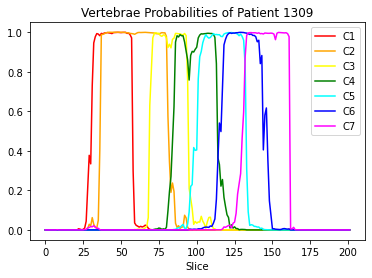

In [59]:
colors = ['red', 'orange', 'yellow', 'g', 'cyan', 'blue', 'magenta']
for i in range(7):
    plt.plot(range(202), pred_verts.reshape(-1, 7)[:, i], label=f'C{i+1}', color=colors[i])
plt.legend()
plt.title('Vertebrae Probabilities of Patient 1309')
plt.xlabel('Slice')
plt.savefig('vert-prob.jpg', dpi=300)

In [55]:
probs = (pred_verts * pred_fracs).reshape(-1, 7).sum(axis=1) / pred_verts.reshape(-1, 7).sum(axis=1)
probs.max()

nan

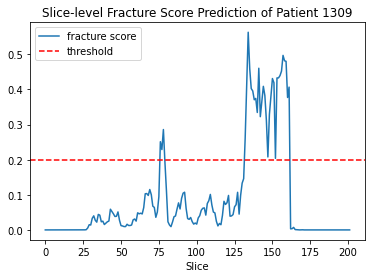

In [79]:
plt.plot(range(202), probs, label='fracture score')
plt.axhline(y=.2, color='r', linestyle='--', label='threshold')
plt.title('Slice-level Fracture Score Prediction of Patient 1309')
plt.xlabel('Slice')
plt.legend()
plt.savefig('slice-frac-prob.jpg', dpi=300)

In [76]:
for i in range(probs.size):
    if probs[i] > 0.2:
        print(i)

76
77
78
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161


In [37]:
df_test = df_fracture[df_fracture.StudyInstanceUID == '1.2.826.0.1.3680043.1309']
df_test

,StudyInstanceUID,Slice,ImageHeight,ImageWidth,SliceThickness,ImagePositionPatient_x,ImagePositionPatient_y,ImagePositionPatient_z,C1,C2,...,C7,patient_overall,C1_frac,C2_frac,C3_frac,C4_frac,C5_frac,C6_frac,C7_frac,Fold
66828,1.2.826.0.1.3680043.1309,1,512,512,1.0,-70.34082,-230.34082,557.0,0.013920,0.017994,...,0.008020,1,0,0,0,0,0,0,1,1
66829,1.2.826.0.1.3680043.1309,2,512,512,1.0,-70.34082,-230.34082,556.0,0.009254,0.008323,...,0.002791,1,0,0,0,0,0,0,1,1
66830,1.2.826.0.1.3680043.1309,3,512,512,1.0,-70.34082,-230.34082,555.0,0.008224,0.007531,...,0.001800,1,0,0,0,0,0,0,1,1
66831,1.2.826.0.1.3680043.1309,4,512,512,1.0,-70.34082,-230.34082,554.0,0.007148,0.005111,...,0.001235,1,0,0,0,0,0,0,1,1
66832,1.2.826.0.1.3680043.1309,5,512,512,1.0,-70.34082,-230.34082,553.0,0.006869,0.006027,...,0.002328,1,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67025,1.2.826.0.1.3680043.1309,198,512,512,1.0,-70.34082,-230.34082,360.0,0.003098,0.000444,...,0.000232,1,0,0,0,0,0,0,1,1
67026,1.2.826.0.1.3680043.1309,199,512,512,1.0,-70.34082,-230.34082,359.0,0.002619,0.000494,...,0.000380,1,0,0,0,0,0,0,1,1
67027,1.2.826.0.1.3680043.1309,200,512,512,1.0,-70.34082,-230.34082,358.0,0.002098,0.000531,...,0.000898,1,0,0,0,0,0,0,1,1
67028,1.2.826.0.1.3680043.1309,201,512,512,1.0,-70.34082,-230.34082,357.0,0.001908,0.000530,...,0.000900,1,0,0,0,0,0,0,1,1


In [38]:
preds = pred_fracs
pred_frac_cols = [f'C{j}_frac_pred' for j in range(1, NUM_VERTEBRAE+1)]
df_test[pred_frac_cols] = preds.reshape(-1, 7)
df_test

,StudyInstanceUID,Slice,ImageHeight,ImageWidth,SliceThickness,ImagePositionPatient_x,ImagePositionPatient_y,ImagePositionPatient_z,C1,C2,...,C6_frac,C7_frac,Fold,C1_frac_pred,C2_frac_pred,C3_frac_pred,C4_frac_pred,C5_frac_pred,C6_frac_pred,C7_frac_pred
66828,1.2.826.0.1.3680043.1309,1,512,512,1.0,-70.34082,-230.34082,557.0,0.013920,0.017994,...,0,1,1,1.728535e-06,6.496906e-06,0.0,0.000000e+00,5.960464e-08,0.000000e+00,4.529953e-06
66829,1.2.826.0.1.3680043.1309,2,512,512,1.0,-70.34082,-230.34082,556.0,0.009254,0.008323,...,0,1,1,4.768372e-07,8.940697e-07,0.0,5.960464e-08,4.172325e-07,2.980232e-07,2.753735e-05
66830,1.2.826.0.1.3680043.1309,3,512,512,1.0,-70.34082,-230.34082,555.0,0.008224,0.007531,...,0,1,1,6.675720e-06,6.854534e-06,0.0,0.000000e+00,5.960464e-08,1.192093e-07,3.945827e-05
66831,1.2.826.0.1.3680043.1309,4,512,512,1.0,-70.34082,-230.34082,554.0,0.007148,0.005111,...,0,1,1,7.748604e-07,8.344650e-07,0.0,0.000000e+00,5.960464e-08,5.960464e-08,1.877546e-05
66832,1.2.826.0.1.3680043.1309,5,512,512,1.0,-70.34082,-230.34082,553.0,0.006869,0.006027,...,0,1,1,6.854534e-06,7.212162e-06,0.0,0.000000e+00,0.000000e+00,5.960464e-08,2.044439e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67025,1.2.826.0.1.3680043.1309,198,512,512,1.0,-70.34082,-230.34082,360.0,0.003098,0.000444,...,0,1,1,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,1.192093e-07
67026,1.2.826.0.1.3680043.1309,199,512,512,1.0,-70.34082,-230.34082,359.0,0.002619,0.000494,...,0,1,1,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
67027,1.2.826.0.1.3680043.1309,200,512,512,1.0,-70.34082,-230.34082,358.0,0.002098,0.000531,...,0,1,1,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
67028,1.2.826.0.1.3680043.1309,201,512,512,1.0,-70.34082,-230.34082,357.0,0.001908,0.000530,...,0,1,1,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


In [ ]:
df_patient = df_test
# patient true fracture information
true_frac_cols = ['patient_overall'] + [f'C{j}_frac' for j in range(1, NUM_VERTEBRAE+1)]
true_frac = df_patient.iloc[0][true_frac_cols].values  # shape (8,)
true_fracs.append(true_frac)
# predicted fracture probabilities
pred_frac = []

In [35]:
for mode in ['multitask']:    
    true_fracs = []
    pred_fracs = []
    for patient_uid in tqdm(df_test.StudyInstanceUID.unique()):
        df_patient = df_test[df_test.StudyInstanceUID == patient_uid]
        # patient true fracture information
        true_frac_cols = ['patient_overall'] + [f'C{j}_frac' for j in range(1, NUM_VERTEBRAE+1)]
        true_frac = df_patient.iloc[0][true_frac_cols].values  # shape (8,)
        true_fracs.append(true_frac)
        # predicted fracture probabilities
        pred_frac = []
        if mode == 'single':
            f = df_patient['frac_pred'].values  # shape (N,)
            for j in range(1, NUM_VERTEBRAE+1):
                v_j = df_patient[f'C{j}']  # shape (N,)
                p_j = np.average(f, weights=v_j) if v_j.sum() > 0 else 0
                pred_frac.append(p_j)
        else:
            for j in range(1, NUM_VERTEBRAE+1):
                f_j = df_patient[f'C{j}_frac_pred']  # shape (N,)
                v_j = df_patient[f'C{j}']  # shape (N,)
                p_j = np.average(f_j, weights=v_j) if v_j.sum() > 0 else 0
                pred_frac.append(p_j)
        pred_overall = 1 - np.prod(1 - np.array(pred_frac))
        pred_frac = np.array([pred_overall] + pred_frac)  # shape (8,)
        pred_fracs.append(pred_frac)
    true_fracs = np.stack(true_fracs).astype(np.uint8)
    pred_fracs = np.stack(pred_fracs)
    
    pred_frac_logits = np.log(pred_fracs / (1 - pred_fracs))
    
    loss = loss_fn(
        torch.as_tensor(pred_frac_logits).to(DEVICE), 
        torch.as_tensor(true_fracs).to(DEVICE)
    )
    print(f'loss: {loss}')
    
    results[mode] = (true_fracs, pred_fracs)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
# load the training set: train on folds 1 ~ NUM_FOLDS-1
ds_train = ImageDataset(df_fracture[df_fracture.Fold != 0], PATH_IMAGES)
# load the test set: test on fold 0
ds_test = ImageDataset(df_fracture[df_fracture.Fold == 0], PATH_IMAGES)

model_name = 'Inception_V3'
modes = ['single', 'multimodal', 'multitask']
for mode in modes:
    print(f'Mode: {mode}')
    # initialize the model
    model = create_model(mode, model_name)
    # train and evaluate the model
    true_fracs, pred_verts, pred_fracs, loss = train(model, ds_train, ds_test)
    print(f'final loss: {loss}')
    for threshold in np.linspace(0.05, 0.95, 19):
        metrics = get_metrics(true_fracs, pred_fracs, threshold=threshold)
        print(f'threshold: {threshold}')
        print(metrics)
    np.save(f'{mode}_true_fracs.npy', true_fracs)
    np.save(f'{mode}_pred_fracs.npy', pred_fracs)
    torch.save(model.state_dict(), f'{mode}.pth')
    
    # clean cache
    del model
    gc.collect()
    torch.cuda.empty_cache()
    print()
    
# clean cache
del ds_train, ds_test
gc.collect()
torch.cuda.empty_cache()

In [30]:
torch.save(model.state_dict(), f'{mode}.pth')

In [28]:
modes = ['single', 'multimodal', 'multitask']
results = dict()
for mode in modes:    
    df_test = df_fracture[df_fracture.Fold == 0]
    preds = np.load(f'{mode}_pred_fracs.npy')
    if mode == 'single':
        df_test['frac_pred'] = preds.reshape(-1, 1)
    else:
        pred_frac_cols = [f'C{j}_frac_pred' for j in range(1, NUM_VERTEBRAE+1)]
        df_test[pred_frac_cols] = preds.reshape(-1, 7)
    
    true_fracs = []
    pred_fracs = []
    for patient_uid in tqdm(df_test.StudyInstanceUID.unique()):
        df_patient = df_test[df_test.StudyInstanceUID == patient_uid]
        # patient true fracture information
        true_frac_cols = ['patient_overall'] + [f'C{j}_frac' for j in range(1, NUM_VERTEBRAE+1)]
        true_frac = df_patient.iloc[0][true_frac_cols].values  # shape (8,)
        true_fracs.append(true_frac)
        # predicted fracture probabilities
        pred_frac = []
        if mode == 'single':
            f = df_patient['frac_pred'].values  # shape (N,)
            for j in range(1, NUM_VERTEBRAE+1):
                v_j = df_patient[f'C{j}']  # shape (N,)
                p_j = np.average(f, weights=v_j) if v_j.sum() > 0 else 0
                pred_frac.append(p_j)
        else:
            for j in range(1, NUM_VERTEBRAE+1):
                f_j = df_patient[f'C{j}_frac_pred']  # shape (N,)
                v_j = df_patient[f'C{j}']  # shape (N,)
                p_j = np.average(f_j, weights=v_j) if v_j.sum() > 0 else 0
                pred_frac.append(p_j)
        pred_overall = 1 - np.prod(1 - np.array(pred_frac))
        pred_frac = np.array([pred_overall] + pred_frac)  # shape (8,)
        pred_fracs.append(pred_frac)
    true_fracs = np.stack(true_fracs).astype(np.uint8)
    pred_fracs = np.stack(pred_fracs)
    
#     pred_frac_logits = np.log(pred_fracs / (1 - pred_fracs))
    
#     loss = loss_fn(
#         torch.as_tensor(pred_frac_logits).to(DEVICE), 
#         torch.as_tensor(true_fracs).to(DEVICE)
#     )
#     print(f'loss: {loss}')
    
    results[mode] = (true_fracs, pred_fracs)

100%|██████████| 403/403 [00:04<00:00, 88.58it/s]


In [35]:
results['single'][1].shape

(403, 8)

In [47]:
thresholds = np.linspace(0.05, 0.95, 19)
for mode in modes:
    print(mode)
    metrics = get_metrics(
        results[mode][0][:, 0].flatten(), 
        results[mode][1][:, 0].flatten(), 
        threshold=0.1
    )
    print(metrics)
    print()

single
{'Accuracy': 0.56575682382134, 'Precision': 0.5625, 'Recall': 0.968609865470852, 'F1-score': 0.7116968698517298, 'AUC': 0.7247633283507722}

multimodal
{'Accuracy': 0.6228287841191067, 'Precision': 0.6, 'Recall': 0.9551569506726457, 'F1-score': 0.7370242214532873, 'AUC': 0.7470104633781764}

multitask
{'Accuracy': 0.5533498759305211, 'Precision': 0.5536159600997507, 'Recall': 0.9955156950672646, 'F1-score': 0.7115384615384616, 'AUC': 0.7245142002989536}



In [39]:
mode = 'single'
threshold = 0.1
if True:
    print(mode)
    
    print('vertebra-level')
    metrics = get_metrics(
        results[mode][0][:, 1:].flatten(), 
        results[mode][1][:, 1:].flatten(), 
        threshold=threshold
    )
    print(metrics)
    
    print('patient-level')
    metrics = get_metrics(
        results[mode][0][:, 0].flatten(), 
        results[mode][1][:, 0].flatten(), 
        threshold=threshold
    )
    print(metrics)

single
vertebra-level
{'Accuracy': 0.6231832683445586, 'Precision': 0.19630872483221476, 'Recall': 0.6902654867256637, 'F1-score': 0.30568256041802744, 'AUC': 0.7057848960896032}
patient-level
{'Accuracy': 0.56575682382134, 'Precision': 0.5625, 'Recall': 0.968609865470852, 'F1-score': 0.7116968698517298, 'AUC': 0.7247633283507722}


In [ ]:
# mode = 'multitask'
# if True:
#     df_test = df_fracture[df_fracture.Fold == 0]
#     true_frac_cols = ['patient_overall'] + [f'C{j}_frac' for j in range(1, NUM_VERTEBRAE+1)]
    
#     pred_vert_cols = [f'C{j}_vert_pred' for j in range(1, NUM_VERTEBRAE+1)]
#     pred_frac_cols = [f'C{j}_frac_pred' for j in range(1, NUM_VERTEBRAE+1)]
#     df_test[pred_vert_cols] = pred_verts.reshape(-1, 7)
#     df_test[pred_frac_cols] = pred_fracs.reshape(-1, 7)
    
#     true_fracs = []
#     pred_fracs = []
#     for patient_uid in tqdm(df_test.StudyInstanceUID.unique()):
#         df_patient = df_test[df_test.StudyInstanceUID == patient_uid]
        
#         # patient true fracture information
#         true_frac = df_patient.iloc[0][true_frac_cols].values  # shape (8,)
#         true_fracs.append(true_frac)
        
#         # predicted fracture probabilities
#         pred_frac = []
#         for j in range(1, NUM_VERTEBRAE+1):
#             v_j = df_patient[f'C{j}_vert_pred']  # shape (N,)
#             f_j = df_patient[f'C{j}_frac_pred']  # shape (N,)
#             p_j = np.average(f_j, weights=v_j) if v_j.sum() > 0 else 0
#             pred_frac.append(p_j)
#         pred_overall = 1 - np.prod(1 - np.array(pred_frac))
#         pred_frac = np.array([pred_overall] + pred_frac)  # shape (8,)
#         pred_fracs.append(pred_frac)
    
#     true_fracs = np.stack(true_fracs).astype(np.float)
#     pred_fracs = np.stack(pred_fracs)
#     pred_frac_logits = np.log(pred_fracs / (1 - pred_fracs))
    
#     loss = loss_fn(
#         torch.as_tensor(pred_frac_logits).to(DEVICE), 
#         torch.as_tensor(true_fracs).to(DEVICE)
#     )
#     print(f'loss: {loss}')

In [ ]:
true_fracs.shape

In [ ]:
metrics = get_metrics(
    true_fracs[:, 1:].flatten(), 
    pred_fracs[:, 1:].flatten(), 
    threshold=0.1
)
metrics

In [ ]:
thresholds = np.linspace(0.05, 0.95, 19)
metrics = [get_metrics(true_fracs[:, 1:].flatten(), pred_fracs[:, 1:].flatten(), threshold) for threshold in thresholds]
for metric_name in ['Accuracy', 'Precision', 'Recall', 'F1-score']:
    plt.plot(thresholds, [metric[metric_name] for metric in metrics], label=metric_name)
plt.legend()
plt.show()

In [ ]:
metrics = get_metrics(
    true_fracs[:, 0].flatten(), 
    pred_fracs[:, 0].flatten(), 
    threshold=0.1
)
metrics

In [ ]:
thresholds = np.linspace(0.05, 0.95, 19)
metrics = [get_metrics(true_fracs[:, 0].flatten(), pred_fracs[:, 0].flatten(), threshold) for threshold in thresholds]
for metric_name in ['Accuracy', 'Precision', 'Recall', 'F1-score']:
    plt.plot(thresholds, [metric[metric_name] for metric in metrics], label=metric_name)
plt.legend()
plt.show()